# Random Top-Fill Component Placement

This notebook explores a different random placement strategy - filling from the top but not caring about the left position.

## Strategy

Instead of the traditional "top-left fill" approach, we'll:
- Fill from the **top** (prioritize higher rows)
- **Don't care about left position** (random horizontal placement)
- Use **purely random placement** without optimization
- Test how this affects space utilization and visual layout

## Key Differences

- **Traditional**: Top-left to bottom-right (systematic)
- **This approach**: Top priority, random horizontal (chaotic but top-focused)
- **Goal**: See if random top-fill creates more interesting layouts


In [50]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import random
from typing import List, Tuple, Dict, Optional
from dataclasses import dataclass
from copy import deepcopy

# Load configuration
with open('../config/component_placement_config.json', 'r') as f:
    config = json.load(f)

print("Grid Configuration:")
print(f"Columns: {config['grid_config']['columns']}")
print(f"Rows: {config['grid_config']['rows']}")
print(f"Cell Size: {config['grid_config']['cell_size']}px")

print("\nComponent Specifications:")
for component in config['components']:
    if 'shapes' in component:
        print(f"- {component['name']}: {component['total_count']} total with flexible shapes {component['shapes']}")
    else:
        print(f"- {component['name']}: {component['width']}x{component['height']} (count: {component['count']})")


Grid Configuration:
Columns: 12
Rows: 16
Cell Size: 48px

Component Specifications:
- headline: 5x4 (count: 4)
- github_repo: 3x3 (count: 1)
- branding: 2x2 (count: 3)
- quick_link: 6 total with flexible shapes [{'width': 6, 'height': 1}, {'width': 4, 'height': 2}]


In [51]:
@dataclass
class Component:
    name: str
    width: int
    height: int
    count: int
    can_rotate: bool
    priority: int
    color: str
    
    def __post_init__(self):
        self.instances = []
        for i in range(self.count):
            self.instances.append({
                'id': f"{self.name}_{i+1}",
                'width': self.width,
                'height': self.height,
                'placed': False,
                'position': None
            })

@dataclass
class FlexibleComponent:
    name: str
    shapes: List[Dict[str, int]]
    total_count: int
    can_rotate: bool
    priority: int
    color: str

@dataclass
class Placement:
    component_id: str
    x: int
    y: int
    width: int
    height: int
    color: str

class RandomTopFillPlacer:
    def __init__(self, grid_width: int, grid_height: int):
        self.grid_width = grid_width
        self.grid_height = grid_height
        self.grid = np.zeros((grid_height, grid_width), dtype=int)
        self.placements = []
        
    def can_place(self, x: int, y: int, width: int, height: int) -> bool:
        """Check if a component can be placed at the given position"""
        if x + width > self.grid_width or y + height > self.grid_height:
            return False
        if x < 0 or y < 0:
            return False
            
        # Check if the area is free
        return np.all(self.grid[y:y+height, x:x+width] == 0)
    
    def place_component(self, component_id: str, x: int, y: int, width: int, height: int, color: str) -> bool:
        """Place a component at the given position"""
        if not self.can_place(x, y, width, height):
            return False
            
        # Mark the grid cells as occupied
        self.grid[y:y+height, x:x+width] = 1
        
        # Add to placements
        self.placements.append(Placement(component_id, x, y, width, height, color))
        return True
    
    def get_random_top_position(self, width: int, height: int) -> Optional[Tuple[int, int]]:
        """
        Get a random position prioritizing top rows
        First try to find positions in the top half, then expand downward
        """
        # Start from the top and work down
        for start_row in range(self.grid_height - height + 1):
            # Get all available positions in this row
            row_positions = []
            for x in range(self.grid_width - width + 1):
                if self.can_place(x, start_row, width, height):
                    row_positions.append((x, start_row))
            
            # If we found positions in this row, randomly pick one
            if row_positions:
                return random.choice(row_positions)
        
        return None
    
    def get_available_positions(self, width: int, height: int) -> List[Tuple[int, int]]:
        """Get all available positions for a component of given size"""
        positions = []
        for y in range(self.grid_height - height + 1):
            for x in range(self.grid_width - width + 1):
                if self.can_place(x, y, width, height):
                    positions.append((x, y))
        return positions


In [52]:
def random_brandings_top_fill_algorithm(components: List[Component], flexible_components: List[FlexibleComponent], 
                                       grid_width: int, grid_height: int) -> RandomTopFillPlacer:
    """
    Random brandings first, then top-fill algorithm: 
    1. Place brandings randomly anywhere
    2. Fill the rest prioritizing top rows but random horizontal placement
    """
    placer = RandomTopFillPlacer(grid_width, grid_height)
    
    # Separate brandings from other components
    branding_components = [c for c in components if c.name == 'branding']
    other_components = [c for c in components if c.name != 'branding']
    
    # Step 1: Place brandings randomly anywhere
    print("Step 1: Placing brandings randomly...")
    for component in branding_components:
        for instance in component.instances:
            if instance['placed']:
                continue
                
            # Get all available positions for branding
            positions = placer.get_available_positions(instance['width'], instance['height'])
            
            if positions:
                # Randomly select a position
                x, y = random.choice(positions)
                
                success = placer.place_component(
                    instance['id'], x, y, 
                    instance['width'], instance['height'], 
                    component.color
                )
                if success:
                    instance['placed'] = True
                    instance['position'] = (x, y)
                    print(f"Randomly placed {instance['id']} at ({x}, {y})")
                else:
                    print(f"Failed to place {instance['id']}")
            else:
                print(f"No space for {instance['id']}")
    
    # Step 2: Create a list of remaining components (randomize order)
    print("\nStep 2: Placing remaining components with top-fill strategy...")
    all_components = []
    
    # Add remaining fixed components
    for component in other_components:
        for instance in component.instances:
            all_components.append({
                'type': 'fixed',
                'instance': instance,
                'component': component
            })
    
    # Add flexible components (randomly choose shapes)
    for flexible_component in flexible_components:
        shapes = flexible_component.shapes
        for i in range(flexible_component.total_count):
            # Randomly choose a shape for this instance
            chosen_shape = random.choice(shapes)
            all_components.append({
                'type': 'flexible',
                'instance': {
                    'id': f"{flexible_component.name}_{i+1}",
                    'width': chosen_shape['width'],
                    'height': chosen_shape['height'],
                    'placed': False,
                    'position': None
                },
                'component': flexible_component
            })
    
    # Randomize the order of remaining components
    random.shuffle(all_components)
    
    print(f"Placing {len(all_components)} remaining components in random order...")
    
    # Place remaining components using random top-fill
    for i, item in enumerate(all_components):
        instance = item['instance']
        component = item['component']
        
        if instance['placed']:
            continue
        
        # Try to find a random top position
        position = placer.get_random_top_position(instance['width'], instance['height'])
        
        if position:
            x, y = position
            success = placer.place_component(
                instance['id'], x, y, 
                instance['width'], instance['height'], 
                component.color
            )
            if success:
                instance['placed'] = True
                instance['position'] = (x, y)
                print(f"Top-fill placed {instance['id']} at ({x}, {y}) - {instance['width']}x{instance['height']}")
            else:
                print(f"Failed to place {instance['id']}")
        else:
            print(f"No space for {instance['id']}")
    
    return placer


In [53]:
def visualize_placement(placer: RandomTopFillPlacer, title: str = "Random Top-Fill Placement"):
    """Visualize the component placement with colorful boxes"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 16))
    
    # Draw grid
    for i in range(placer.grid_height + 1):
        ax.axhline(y=i, color='black', linewidth=0.5, alpha=0.3)
    for i in range(placer.grid_width + 1):
        ax.axvline(x=i, color='black', linewidth=0.5, alpha=0.3)
    
    # Draw placed components
    for placement in placer.placements:
        rect = patches.Rectangle(
            (placement.x, placement.y), 
            placement.width, 
            placement.height,
            linewidth=2, 
            edgecolor='black', 
            facecolor=placement.color,
            alpha=0.7
        )
        ax.add_patch(rect)
        
        # Add component ID text
        center_x = placement.x + placement.width / 2
        center_y = placement.y + placement.height / 2
        ax.text(center_x, center_y, placement.component_id, 
                ha='center', va='center', fontsize=8, fontweight='bold')
    
    ax.set_xlim(-0.5, placer.grid_width + 0.5)
    ax.set_ylim(-0.5, placer.grid_height + 0.5)
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Columns')
    ax.set_ylabel('Rows')
    ax.invert_yaxis()  # Invert y-axis so (0,0) is top-left
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    total_cells = placer.grid_width * placer.grid_height
    occupied_cells = np.sum(placer.grid)
    wasted_cells = total_cells - occupied_cells
    efficiency = (occupied_cells / total_cells) * 100
    
    print(f"\nPlacement Statistics:")
    print(f"Total grid cells: {total_cells}")
    print(f"Occupied cells: {occupied_cells}")
    print(f"Wasted cells: {wasted_cells}")
    print(f"Efficiency: {efficiency:.1f}%")
    print(f"Components placed: {len(placer.placements)}")
    
    # Count by component type
    component_counts = {}
    for placement in placer.placements:
        comp_type = placement.component_id.split('_')[0]
        component_counts[comp_type] = component_counts.get(comp_type, 0) + 1
    
    print(f"\nComponent breakdown:")
    for comp_type, count in component_counts.items():
        print(f"  {comp_type}: {count}")
    
    # Analyze top-fill effectiveness
    top_half_placements = [p for p in placer.placements if p.y < placer.grid_height // 2]
    bottom_half_placements = [p for p in placer.placements if p.y >= placer.grid_height // 2]
    
    print(f"\nTop-fill analysis:")
    print(f"  Components in top half: {len(top_half_placements)}")
    print(f"  Components in bottom half: {len(bottom_half_placements)}")
    print(f"  Top-fill ratio: {len(top_half_placements) / len(placer.placements) * 100:.1f}%")


In [54]:
# Create component objects from config
components = []
flexible_components = []

for comp_config in config['components']:
    if 'shapes' in comp_config:
        # This is a flexible component
        flexible_component = FlexibleComponent(
            name=comp_config['name'],
            shapes=comp_config['shapes'],
            total_count=comp_config['total_count'],
            can_rotate=comp_config['can_rotate'],
            priority=comp_config['priority'],
            color=comp_config['color']
        )
        flexible_components.append(flexible_component)
    else:
        # This is a fixed-size component
        component = Component(
            name=comp_config['name'],
            width=comp_config['width'],
            height=comp_config['height'],
            count=comp_config['count'],
            can_rotate=comp_config['can_rotate'],
            priority=comp_config['priority'],
            color=comp_config['color']
        )
        components.append(component)

# Get grid dimensions
grid_width = config['grid_config']['columns']
grid_height = config['grid_config']['rows']

print(f"Grid size: {grid_width}x{grid_height}")
print(f"Total available cells: {grid_width * grid_height}")

# Calculate total space needed
total_space_needed = 0
for component in components:
    space_per_component = component.width * component.height
    total_space = space_per_component * component.count
    total_space_needed += total_space
    print(f"{component.name}: {space_per_component} cells each × {component.count} = {total_space} cells")

# For flexible components, calculate average space needed
for flexible_component in flexible_components:
    avg_space = sum(shape['width'] * shape['height'] for shape in flexible_component.shapes) / len(flexible_component.shapes)
    total_avg_space = avg_space * flexible_component.total_count
    total_space_needed += total_avg_space
    print(f"{flexible_component.name}: ~{avg_space:.1f} cells each × {flexible_component.total_count} = {total_avg_space:.1f} cells (flexible)")

print(f"\nTotal space needed (estimated): {total_space_needed:.1f} cells")
print(f"Space available: {grid_width * grid_height} cells")
print(f"Can fit: {'Yes' if total_space_needed <= grid_width * grid_height else 'No'}")


Grid size: 12x16
Total available cells: 192
headline: 20 cells each × 4 = 80 cells
github_repo: 9 cells each × 1 = 9 cells
branding: 4 cells each × 3 = 12 cells
quick_link: ~7.0 cells each × 6 = 42.0 cells (flexible)

Total space needed (estimated): 143.0 cells
Space available: 192 cells
Can fit: Yes


Running Random Brandings + Top-Fill Algorithm...
Step 1: Placing brandings randomly...
Randomly placed branding_1 at (0, 7)
Randomly placed branding_2 at (2, 8)
Randomly placed branding_3 at (2, 12)

Step 2: Placing remaining components with top-fill strategy...
Placing 11 remaining components in random order...
Top-fill placed github_repo_1 at (5, 0) - 3x3
Top-fill placed headline_2 at (0, 0) - 5x4
Top-fill placed headline_1 at (6, 3) - 5x4
Top-fill placed quick_link_1 at (8, 0) - 4x2
Top-fill placed headline_4 at (6, 7) - 5x4
Top-fill placed quick_link_4 at (1, 4) - 4x2
Top-fill placed headline_3 at (6, 11) - 5x4
Top-fill placed quick_link_3 at (2, 6) - 4x2
Top-fill placed quick_link_5 at (0, 10) - 4x2
Top-fill placed quick_link_2 at (0, 14) - 4x2
Top-fill placed quick_link_6 at (4, 15) - 6x1


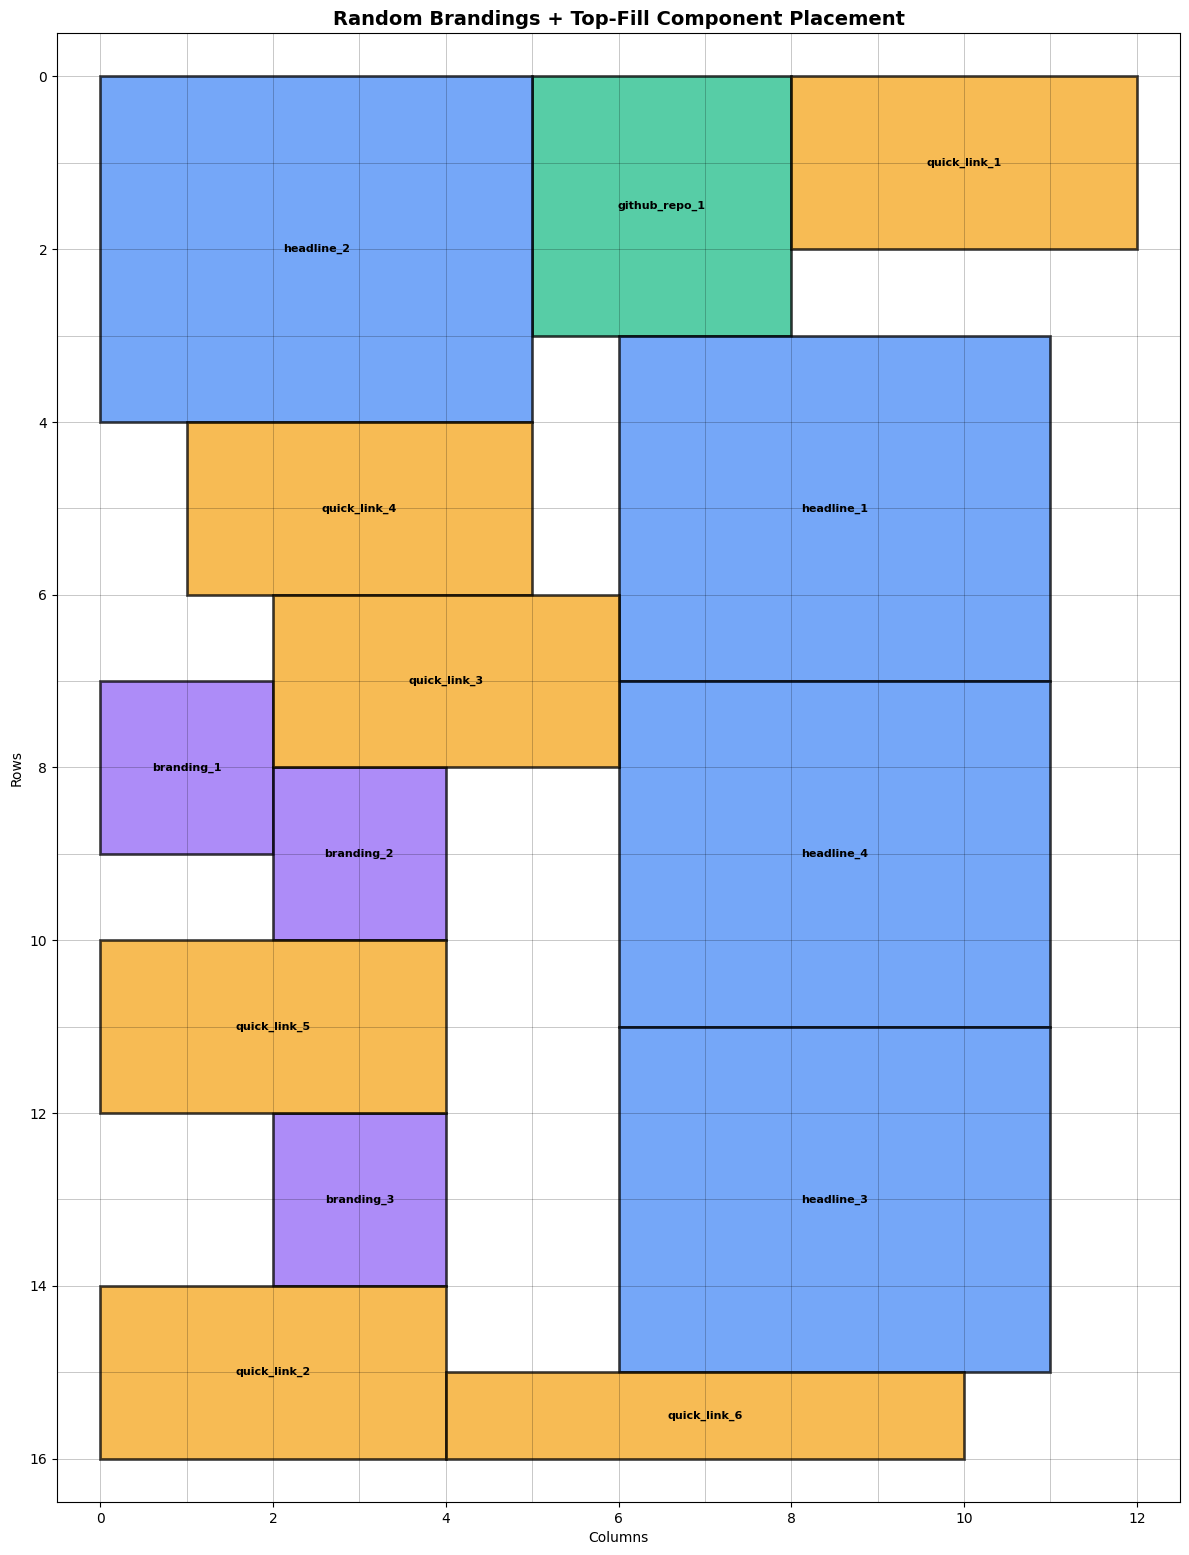


Placement Statistics:
Total grid cells: 192
Occupied cells: 147
Wasted cells: 45
Efficiency: 76.6%
Components placed: 14

Component breakdown:
  branding: 3
  github: 1
  headline: 4
  quick: 6

Top-fill analysis:
  Components in top half: 8
  Components in bottom half: 6
  Top-fill ratio: 57.1%


In [55]:
# Run the random brandings + top-fill algorithm
print("Running Random Brandings + Top-Fill Algorithm...")
print("=" * 60)

placer = random_brandings_top_fill_algorithm(components, flexible_components, grid_width, grid_height)

# Visualize the result
visualize_placement(placer, "Random Brandings + Top-Fill Component Placement")


In [56]:
def export_to_frontend_format(placer: RandomTopFillPlacer, components: List[Component], flexible_components: List[FlexibleComponent]) -> dict:
    """Export the placement solution in frontend-compatible format"""
    
    # Create component mapping for easy lookup
    component_map = {}
    for component in components:
        for instance in component.instances:
            component_map[instance['id']] = component
    
    for flexible_component in flexible_components:
        for placement in placer.placements:
            if flexible_component.name in placement.component_id:
                component_map[placement.component_id] = flexible_component
    
    # Convert placements to frontend format
    frontend_components = []
    
    for placement in placer.placements:
        component = component_map.get(placement.component_id)
        
        # Determine component type based on name
        if 'headline' in placement.component_id:
            comp_type = 'headline'
        elif 'github_repo' in placement.component_id:
            comp_type = 'gitRepo'
        elif 'branding' in placement.component_id:
            comp_type = 'branding'
        elif 'quick_link' in placement.component_id:
            comp_type = 'quickLink'
        else:
            comp_type = 'unknown'
        
        frontend_component = {
            'id': placement.component_id,
            'type': comp_type,
            'position': {
                'row': placement.y + 1,  # Frontend uses 1-based indexing
                'column': placement.x + 1,
                'width': placement.width,
                'height': placement.height
            },
            'clickable': True,
            'url': f'https://example.com/{placement.component_id}'
        }
        
        # Add type-specific properties
        if comp_type == 'headline':
            frontend_component.update({
                'title': f'Headline {placement.component_id.split("_")[1]}',
                'description': f'Description for {placement.component_id}',
                'source': 'Tech News',
                'publishedAt': '2025-09-27T10:00:00Z',
                'priority': 1
            })
        elif comp_type == 'gitRepo':
            frontend_component.update({
                'name': f'repo-{placement.component_id.split("_")[1]}',
                'stars': random.randint(1000, 100000),
                'description': f'GitHub repository description for {placement.component_id}'
            })
        elif comp_type == 'branding':
            frontend_component.update({
                'text': 'BIT' if 'bit' in placement.component_id else 'BY',
                'variant': 'bit' if 'bit' in placement.component_id else 'by'
            })
        elif comp_type == 'quickLink':
            frontend_component.update({
                'title': f'Quick Link {placement.component_id.split("_")[1]}'
            })
        
        frontend_components.append(frontend_component)
    
    # Create the complete layout
    layout = {
        'gridConfig': {
            'columns': placer.grid_width,
            'rows': placer.grid_height,
            'cellSize': 48
        },
        'components': frontend_components
    }
    
    return layout

# Export the current placement to frontend format
frontend_layout = export_to_frontend_format(placer, components, flexible_components)

# Save to file
import json
with open('../data/random_top_fill_layout.json', 'w') as f:
    json.dump(frontend_layout, f, indent=2)

print("Frontend layout exported to: ../data/random_top_fill_layout.json")
print(f"Total components: {len(frontend_layout['components'])}")

# Display the exported layout
print("\nExported Layout Preview:")
print("=" * 40)
for comp in frontend_layout['components']:
    pos = comp['position']
    print(f"{comp['id']}: {comp['type']} at ({pos['column']}, {pos['row']}) - {pos['width']}x{pos['height']}")


Frontend layout exported to: ../data/random_top_fill_layout.json
Total components: 14

Exported Layout Preview:
branding_1: branding at (1, 8) - 2x2
branding_2: branding at (3, 9) - 2x2
branding_3: branding at (3, 13) - 2x2
github_repo_1: gitRepo at (6, 1) - 3x3
headline_2: headline at (1, 1) - 5x4
headline_1: headline at (7, 4) - 5x4
quick_link_1: quickLink at (9, 1) - 4x2
headline_4: headline at (7, 8) - 5x4
quick_link_4: quickLink at (2, 5) - 4x2
headline_3: headline at (7, 12) - 5x4
quick_link_3: quickLink at (3, 7) - 4x2
quick_link_5: quickLink at (1, 11) - 4x2
quick_link_2: quickLink at (1, 15) - 4x2
quick_link_6: quickLink at (5, 16) - 6x1
